# The Transformer of Chollet
The Transformer of Chollet (2021) is used with the English-Dutch dataset instead of the English-Spanish dataset used in Chapter 11 of *Deep Learning with Python*.

In [1]:
!wget https://www.manythings.org/anki/nld-eng.zip
!unzip -q nld-eng.zip

--2022-12-13 10:11:36--  https://www.manythings.org/anki/nld-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2507659 (2.4M) [application/zip]
Saving to: ‘nld-eng.zip.1’

nld-eng.zip.1       100%[===================>]   2.39M  1.49MB/s    in 1.6s    

2022-12-13 10:11:38 (1.49 MB/s) - ‘nld-eng.zip.1’ saved [2507659/2507659]

replace _about.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace nld.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


In [2]:
text_file = "nld.txt"
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    english, dutch, copyright = line.split("\t")
    dutch = "[start] " + dutch + " [end]"
    text_pairs.append((english, dutch))

In [3]:
import random
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples:num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples:]

Vectorizing the English and Dutch text pairs

In [4]:
import tensorflow as tf
import string
import re
from tensorflow.python.keras import layers

strip_chars = string.punctuation
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")

vocab_size = 15000
sequence_length = 20

source_vectorization = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
target_vectorization = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_english_texts = [pair[0] for pair in train_pairs]
train_dutch_texts = [pair[1] for pair in train_pairs]
source_vectorization.adapt(train_english_texts)
target_vectorization.adapt(train_dutch_texts)

Preparing datasets for the translation task

In [5]:
batch_size = 64

def format_dataset(eng, nld):
    eng = source_vectorization(eng)
    nld = target_vectorization(nld)
    return ({
        "english": eng,
        "dutch": nld[:, :-1],
    }, nld[:, 1:])

def make_dataset(pairs):
    eng_texts, nld_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    nld_texts = list(nld_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, nld_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)
test_ds = make_dataset(test_pairs)

In [6]:
for inputs, targets in train_ds.take(1):
    print(f"inputs['english'].shape: {inputs['english'].shape}")
    print(f"inputs['dutch'].shape: {inputs['dutch'].shape}")
    print(f"targets.shape: {targets.shape}")

inputs['english'].shape: (64, 20)
inputs['dutch'].shape: (64, 20)
targets.shape: (64, 20)


Sequence to sequence learning for Transformer model

In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = tf.keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

In [ ]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = tf.keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)

Positional Embedding

In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

End to end transformer

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import LayerNormalization

embed_dim = 256
dense_dim = 2048
num_heads = 8

encoder_inputs = tf.keras.Input(shape=(None,), dtype="int64", name="english")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)

decoder_inputs = tf.keras.Input(shape=(None,), dtype="int64", name="dutch")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = tf.keras.layers.Dense(vocab_size, activation="softmax")(x)
transformer = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

Train

In [ ]:
transformer.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
history = transformer.fit(train_ds, epochs=30, validation_data=val_ds)

Epoch 1/30
772/772 [==============================] - 63s 68ms/step - loss: 1.6902 - accuracy: 0.7672 - val_loss: 1.3626 - val_accuracy: 0.8143
Epoch 2/30
772/772 [==============================] - 53s 68ms/step - loss: 1.2385 - accuracy: 0.8231 - val_loss: 1.1098 - val_accuracy: 0.8390
Epoch 3/30
772/772 [==============================] - 53s 68ms/step - loss: 1.0827 - accuracy: 0.8429 - val_loss: 1.0126 - val_accuracy: 0.8511
Epoch 4/30
772/772 [==============================] - 53s 68ms/step - loss: 0.9744 - accuracy: 0.8564 - val_loss: 0.9360 - val_accuracy: 0.8620
Epoch 5/30
772/772 [==============================] - 53s 68ms/step - loss: 0.9105 - accuracy: 0.8654 - val_loss: 0.9126 - val_accuracy: 0.8659
Epoch 6/30
772/772 [==============================] - 53s 69ms/step - loss: 0.8734 - accuracy: 0.8724 - val_loss: 0.8970 - val_accuracy: 0.8695
Epoch 7/30
772/772 [==============================] - 53s 68ms/step - loss: 0.8411 - accuracy: 0.8777 - val_loss: 0.8923 - val_accuracy:

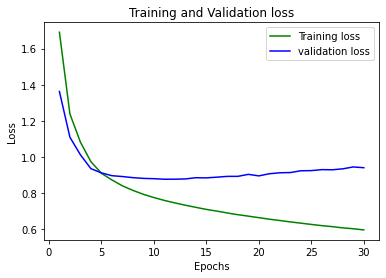

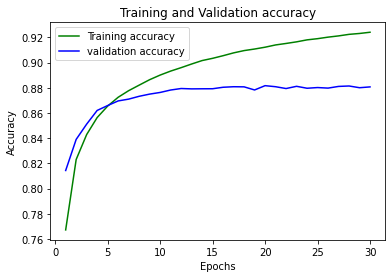

In [ ]:
import matplotlib.pyplot as plt

loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,31)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,31)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Translating new sentences

In [ ]:
test_acc = transformer.evaluate(test_ds)

166/166 [==============================] - 6s 33ms/step - loss: 0.9227 - accuracy: 0.8811


In [ ]:
import numpy as np
import random

random.seed(10)

nld_vocab = target_vectorization.get_vocabulary()
nld_index_lookup = dict(zip(range(len(nld_vocab)), nld_vocab))
max_decoded_sentence_length = 20

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization(
            [decoded_sentence])[:, :-1]
        predictions = transformer(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = nld_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(20):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence))

-
I don't think Tom even saw me.
[start] ik denk niet dat tom me eens heeft gezien [end]
-
I'm an archaeologist.
[start] ik ben een een een een een een een een een een een een een een een een een een
-
Who fired Tom?
[start] wie heeft tom ontslagen [end]
-
We need to invest in clean, renewable energy.
[start] we moeten in de [end]
-
Ignore it.
[start] je moet in [end]
-
Tom is lying to you.
[start] tom liegt tegen je [end]
-
It's very difficult to know yourself.
[start] het is heel moeilijk om te kunnen weten [end]
-
Are you in danger?
[start] zijn jullie in gevaar [end]
-
How many days do you estimate it'll take Tom to do that?
[start] hoeveel dagen staan jullie om tom zal dat er mee mee te doen [end]
-
What do you have in your hand?
[start] wat hebt ge in uw hand [end]
-
Why shouldn't I do that?
[start] waarom zou ik dat niet moeten doen [end]
-
My aunt sent me a birthday present.
[start] mijn tante heb me een cadeau naar er een cadeau geweest [end]
-
I hear that.
[start] dat hoor ik

### Deel 2

We willen dit model nu verbeteren. Bedenk een (mogelijke) verbetering, voer deze uit een licht het volgende toe:

- Welke verbetering je uitvoert en waarom je denkt dat dit voor een verbetering zal zorgen
- Welke maat je gebruikt om de verbetering te meten, en waarom
- Hoeveel je model verbeterd (of verslechterd) is
- In het geval van geen verbetering, een mogelijke verklaring waarom het niet werkte.

Houd je antwoorden kort en bondig.

# The change: theory

Chollet uses the RMSProp optimizer in his code (2021). Using the Adam optimization algorithm may help the model converge faster and potentially achieve better performance than using the default optimizer. Adam combines the advantages of both SGD and RMSProp, and can adaptively adjust the learning rates of different parameters in the model based on the historical gradient information. This can help the model avoid getting stuck in suboptimal solutions and improve its convergence.

Chollet's model achieves an accuracy of 0.8811 with the RMSProp optimizer. Lets see if we can achieve a better accuracy with the Adam optimizer.

# The change: practical

In [7]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = tf.keras.Sequential(
            [layers.Dense(dense_dim, activation='relu'),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = tf.keras.Sequential(
            [layers.Dense(dense_dim, activation='relu'),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)

class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import LayerNormalization

embed_dim = 256
dense_dim = 2048
num_heads = 8

encoder_inputs = tf.keras.Input(shape=(None,), dtype="int64", name="english")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)

decoder_inputs = tf.keras.Input(shape=(None,), dtype="int64", name="dutch")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = tf.keras.layers.Dense(vocab_size, activation="softmax")(x)
transformer = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [8]:
transformer.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
history = transformer.fit(train_ds, epochs=20, validation_data=val_ds)

Epoch 1/20
772/772 [==============================] - 57s 69ms/step - loss: 1.6717 - accuracy: 0.7618 - val_loss: 1.1124 - val_accuracy: 0.8233
Epoch 2/20
772/772 [==============================] - 53s 69ms/step - loss: 0.9546 - accuracy: 0.8427 - val_loss: 0.8273 - val_accuracy: 0.8613
Epoch 3/20
772/772 [==============================] - 53s 69ms/step - loss: 0.7186 - accuracy: 0.8711 - val_loss: 0.7167 - val_accuracy: 0.8772
Epoch 4/20
772/772 [==============================] - 54s 69ms/step - loss: 0.5850 - accuracy: 0.8871 - val_loss: 0.6747 - val_accuracy: 0.8831
Epoch 5/20
772/772 [==============================] - 53s 69ms/step - loss: 0.4969 - accuracy: 0.8984 - val_loss: 0.6532 - val_accuracy: 0.8875
Epoch 6/20
772/772 [==============================] - 53s 69ms/step - loss: 0.4308 - accuracy: 0.9073 - val_loss: 0.6459 - val_accuracy: 0.8896
Epoch 7/20
772/772 [==============================] - 56s 73ms/step - loss: 0.3823 - accuracy: 0.9143 - val_loss: 0.6452 - val_accuracy:

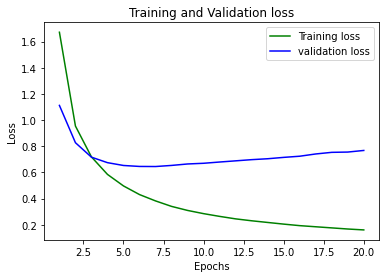

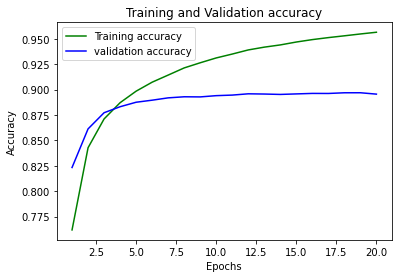

In [9]:
import matplotlib.pyplot as plt

loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [10]:
test_acc = transformer.evaluate(test_ds)

166/166 [==============================] - 6s 35ms/step - loss: 0.7687 - accuracy: 0.8953


In [12]:
import numpy as np
random.seed(10)

nld_vocab = target_vectorization.get_vocabulary()
nld_index_lookup = dict(zip(range(len(nld_vocab)), nld_vocab))
max_decoded_sentence_length = 20

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization(
            [decoded_sentence])[:, :-1]
        predictions = transformer(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = nld_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(20):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence))

-
Tom and Mary moved to Australia.
[start] tom en maria naar australië verhuisd [end]
-
How did you convince them?
[start] hoe heeft u gevraagd ze [end]
-
Don't make fun of foreigners.
[start] maak geen schrik om buitenlanders [end]
-
I like classical music.
[start] ik hou van klassieke muziek [end]
-
Tom's insane.
[start] tom is waanzinnig [end]
-
I love chicken.
[start] ik hou van kip [end]
-
I can't think of any place I'd rather be.
[start] ik kan niet zo veel mogelijk [end]
-
I wish I could buy that guitar.
[start] ik wou dat ik de wijn kon kopen [end]
-
The wind changed directions.
[start] de wind veranderde van richting [end]
-
This skirt is a little too tight.
[start] deze rok is een beetje te strak [end]
-
I was tired from the work.
[start] ik was moe van het werk [end]
-
Tom has been recalled.
[start] tom is al te vergiftigen [end]
-
Gasoline is used for fuel.
[start] benzine is brandstof gebruikt [end]
-
I asked Tom to wait.
[start] ik vroeg tom om te wachten [end]
-
Tom took

# Evaluatie

The improved model scores a test accuracy of 0.8953 instead of Chollet's 0.8811. De sentences are about the same for both models. So using the Adam optimizer is an improvement for the Transformer model. 

I also tried using the GELU activation function instead of ReLU, since GELU is used in most of the Transformer models. But the models accuracy is decreasing when using GELU.